In [1]:
import torch
import numpy as np
from torchvision.datasets import MNIST
import torchvision.transforms as tf
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import imageio
from torch.utils.data import DataLoader as DL
import os

In [2]:
torch.cuda.is_available()
torch.manual_seed(1)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
device

'cuda'

MNIST Dataset

---

Import from `datasets`

In [5]:
transform = tf.Compose([tf.ToTensor(), tf.Normalize((0.1307), (0.3081,))])

In [6]:
train_ds = DL(MNIST(root="./data", train=True, download = True, transform= transform) ,batch_size=35)

In [7]:
test_ds = DL(MNIST(root="./data", train=False, download = True, transform= transform) ,batch_size = 35)

In [8]:
ind = iter(train_ds)

In [9]:
train_batches = len(ind)

In [10]:
class encoder(torch.nn.Module):
    def __init__(self, input_size, latent_size):
        super().__init__()
        self.bn = latent_size
        self.input_size = input_size
        self.fc1 = nn.Linear(input_size,latent_size*2)
        self.fc2 = nn.Linear(latent_size*2, latent_size)
        self.mu_maker  = nn.Linear(latent_size, latent_size)
        self.sigma_maker = nn.Linear(latent_size, latent_size)
        self.latent = None 
        self.sigma = None
        self.mu = None
    def forward(self,x):
        m = torch.flatten(x, 1)
        self.mu = self.mu_maker(self.fc2(self.fc1(m)))
        self.sigma = self.sigma_maker(self.fc2(self.fc1(m)))
        self.latent = self.mu + self.sigma * torch.randn_like(self.sigma) # may cause an issue if variable created on the cpu
        return(self.latent)     

In [11]:
class decoder(torch.nn.Module):
    def __init__(self,latent_size,output_size):
        super().__init__()
        self.bn = latent_size
        self.fc1 = nn.Linear(latent_size, latent_size*2)
        self.fc2 = nn.Linear(latent_size*2, output_size)
    def forward(self, z):
        return (self.fc2(torch.sigmoid(self.fc1(z))))

In [12]:
ec = encoder(784,20)
dc =  decoder(20, 784)
dc

decoder(
  (fc1): Linear(in_features=20, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=784, bias=True)
)

In [13]:
class VariationalAutoencoder(torch.nn.Module):
    def __init__(self, input_size, latent_size):
        super().__init__()
        self.bn = latent_size
        self.input_size = input_size
        self.encoder = encoder(self.input_size, self.bn)
        self.decoder = decoder(self.bn, self.input_size)
    def forward(self,x):
        return self.decoder(torch.sigmoid(self.encoder(x)))
    

In [14]:
loss_fn = torch.nn.MSELoss()

In [15]:
y = next(ind)

In [16]:
y[0].shape

torch.Size([35, 1, 28, 28])

In [17]:
y[1]

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0])

In [18]:
img = torch.randn(35, 1, 28, 28)
op = ec(img)
print(op.shape)

torch.Size([35, 20])


In [19]:
vae = VariationalAutoencoder(784,32)

In [20]:
train_losses = []
test_losses = []
opt =  torch.optim.Adam(vae.parameters(), lr  = 0.001, weight_decay=1e-5)

In [21]:
# vae.to(device)

In [22]:
torch.cuda.memory_allocated()

0

In [23]:
def calc_loss(dl,model):
    model.eval()
    loss = 0
    count = 0
    for index,(image, target) in enumerate(dl):
        image = image.to(device)
        flat_img = torch.flatten(image, 1)
        loss = loss + loss_fn(model(image), flat_img).item()
        count = count + 1
    return loss/count

In [24]:
# calc_loss(test_ds, vae)
# print(calc_loss(train_ds, vae))

In [25]:
len(train_ds.dataset)
NUM_EPOCH = 4
LAMBDA = 0.5

In [26]:
sig_ = torch.randn(10)
print(torch.diag(sig_**2))

tensor([[1.6610e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 3.1495e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 6.4924e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 2.4287e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.1407e-01, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0120e-04,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.2999e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000

In [27]:
def StandardGaussianKL(mu, sigma):
    # mu is mean and sigma is the deviation
    # aggregate over every dimension in mu and sigma to calculate the loss
    loss = torch.tensor(0.0)
    for i in range(mu.shape[0]):
        mu_ = mu[i,:]
        # print(mu_.shape)
        sigma_ = sigma[i,:]
        cov_ = torch.diag(sigma_**2)
        inv_cov = torch.diag(1/(sigma_**2))
        # print(torch.det(cov_).shape)
        assert torch.det(cov_) != 0
        # calculate KL loss between the standard gaussian and the distribution
        loss += 0.5 * torch.log(1/torch.det(cov_)) + mu_.T@inv_cov@mu_ - 0.5*mu.shape[1]
    return loss

In [28]:
x = torch.randn(35, 784)
op = vae(x)
print(op.shape)
print(vae.encoder.mu)
print(vae.encoder.sigma)
# StandardGaussianKL(vae.encoder.mu, vae.encoder.sigma)

torch.Size([35, 784])
tensor([[-0.2611,  0.0712, -0.1079,  ..., -0.0258, -0.0618,  0.0071],
        [-0.5228, -0.2801, -0.0752,  ...,  0.0577,  0.0893,  0.1862],
        [ 0.2836,  0.1074, -0.3176,  ...,  0.4451,  0.0042,  0.0392],
        ...,
        [ 0.0637, -0.0362,  0.0196,  ...,  0.0735,  0.1097,  0.0100],
        [-0.2686, -0.0369, -0.3082,  ...,  0.1152,  0.0639,  0.2021],
        [-0.3669, -0.0022, -0.0263,  ...,  0.3586,  0.0044, -0.1748]],
       grad_fn=<AddmmBackward0>)
tensor([[-0.2643, -0.1096, -0.0050,  ..., -0.0457, -0.1275, -0.2168],
        [ 0.2030, -0.3247,  0.0433,  ...,  0.1040, -0.2179, -0.0642],
        [-0.6713, -0.0071,  0.4734,  ..., -0.0396, -0.2568, -0.1595],
        ...,
        [-0.2381, -0.1075,  0.0621,  ..., -0.4163, -0.3765,  0.0238],
        [-0.4877, -0.2271,  0.2658,  ..., -0.0514, -0.0186, -0.3186],
        [-0.4707, -0.0223,  0.3918,  ...,  0.0674, -0.1623, -0.5102]],
       grad_fn=<AddmmBackward0>)


In [29]:
for epoch in (range(NUM_EPOCH)):
    for index,(image, target) in (enumerate(tqdm(train_ds, leave=True))):
        vae.train()
        opt.zero_grad()
        vae = vae.to(device)
        image = image.to(device)
        flat_img = torch.flatten(image, 1)
        op = vae(image)
        reconstruct_loss = loss_fn(op, flat_img)
        logvar = torch.log(vae.encoder.sigma**2)
        KL_loss = torch.mean(-0.5 * torch.sum(1 + logvar - vae.encoder.mu.pow(2) - logvar.exp(),dim=1),dim=0)
        loss = reconstruct_loss + KL_loss
        loss.backward()
        opt.step()
        if(index %600 == 0):
            train_losses.append(loss.item())
            test_loss = calc_loss(test_ds, vae)
            test_losses.append(test_loss)

100%|██████████| 1715/1715 [00:18<00:00, 93.58it/s] 


In [30]:
print(test_losses[-1])
print(test_losses[0])

0.7167154048289452
1.08072575509965


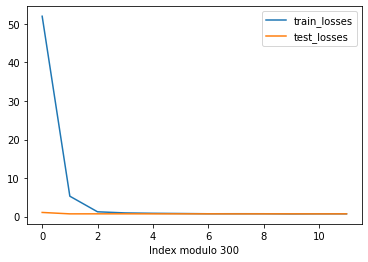

In [31]:
plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label= 'test_losses')
plt.xlabel('Index modulo 300')
plt.legend()

In [32]:
print(test_losses[-1])
vae = vae.to("cpu")
vae.eval()

0.7167154048289452


VariationalAutoencoder(
  (encoder): encoder(
    (fc1): Linear(in_features=784, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=32, bias=True)
    (mu_maker): Linear(in_features=32, out_features=32, bias=True)
    (sigma_maker): Linear(in_features=32, out_features=32, bias=True)
  )
  (decoder): decoder(
    (fc1): Linear(in_features=32, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=784, bias=True)
  )
)

In [33]:
batch  = next(ind)
img = batch[0]

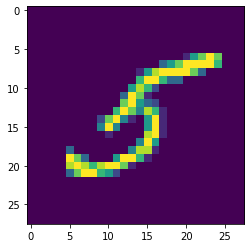

In [34]:
plt.imshow(img[0].permute(1, 2, 0))

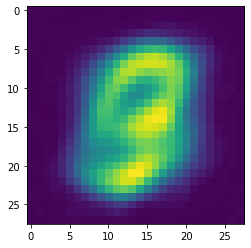

In [35]:
plt.imshow(vae(img[0]).reshape(-1,28,28).permute(1,2,0).detach().numpy())
latent = vae.encoder(img[0])

#### Using the model to visualize the Manifold structure in the latent space

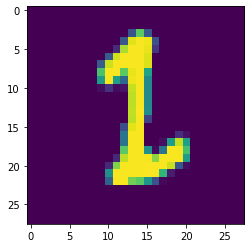

In [36]:
batch_next = next(ind)
image_next = batch_next[0]
plt.imshow(image_next[0].permute(1, 2, 0))
latent_next = vae.encoder(image_next[0])

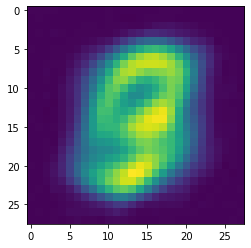

In [42]:
plt.imshow(vae(image_next[0]).reshape(-1,28,28).permute(1,2,0).detach().numpy())

In [37]:
# obtain the latent representations of both of the images
detacher = lambda x: torch.reshape(x, (-1, 28, 28)).detach().numpy()
imager = lambda x: torch.reshape(x, (-1, 28, 28)).permute(1, 2, 0).detach().numpy()
det_trans = tf.Lambda(detacher) 
image_trans = tf.Lambda(imager)

In [38]:
!mkdir images

mkdir: cannot create directory ‘images’: File exists


100%|██████████| 100/100 [00:31<00:00,  3.13it/s]


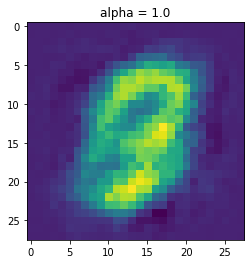

In [39]:
filenames = []
count = 0
for alpha in tqdm(np.linspace(0,1, 100)):
    count = count + 1
    latent_mid = alpha*latent + (1 - alpha)*latent_next
    plt.title('alpha = ' + str(alpha))
    plt.imshow(image_trans(vae.decoder(latent_mid)))
    plt.savefig('images/alpha_' + str(count) + '.png')
    filenames.append('images/alpha_' + str(count) + '.png')

In [40]:
images = []
for file in filenames:
    images.append(imageio.v2.imread(file))
    
imageio.mimsave('ae.gif', images)

![](ae.gif)

In [41]:
for file in filenames:
    os.remove(file)